# Sentiment Analysis 

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
data = pd.read_csv("Sentiment140.tenPercent.sample.tweets.tsv", sep="\t")
data

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,4,@Covergirl08 I take pride in what I do
159998,4,heading to work on the 6


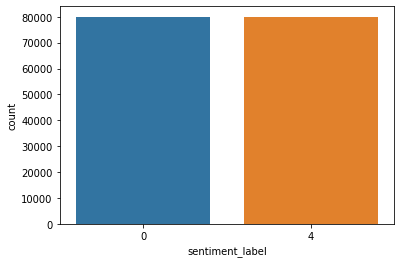

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment_label', data=data)

In [ ]:
def preprocess_text(sen):
    # Remove twitter tags
    sentence = re.sub('@\S*', ' ', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Remove single characters
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(data['tweet_text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[0]

' Hey dear Happy Friday to You Already had your rice bowl for lunch '

In [ ]:
y = data['sentiment_label']
y = y.replace(4, 1)
y.head()

0    1
1    1
2    0
3    0
4    0
Name: sentiment_label, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Simple Neural Network

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          6251900   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [ ]:
batch_size = 4096
epochs = 20

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 19s 700ms/step - loss: 0.6620 - accuracy: 0.6018 - val_loss: 0.6166 - val_accuracy: 0.6626
Epoch 2/20
25/25 [==============================] - 17s 686ms/step - loss: 0.6079 - accuracy: 0.6685 - val_loss: 0.5888 - val_accuracy: 0.6858
Epoch 3/20
25/25 [==============================] - 17s 672ms/step - loss: 0.5907 - accuracy: 0.6823 - val_loss: 0.5789 - val_accuracy: 0.6931
Epoch 4/20
25/25 [==============================] - 17s 668ms/step - loss: 0.5817 - accuracy: 0.6894 - val_loss: 0.5717 - val_accuracy: 0.7000
Epoch 5/20
25/25 [==============================] - 17s 665ms/step - loss: 0.5765 - accuracy: 0.6928 - val_loss: 0.5700 - val_accuracy: 0.6986
Epoch 6/20
25/25 [==============================] - 17s 673ms/step - loss: 0.5691 - accuracy: 0.7001 - val_loss: 0.5678 - val_accuracy: 0.7015
Epoch 7/20
25/25 [==============================] - 17s 674ms/step - loss: 0.5666 - accuracy: 0.7009 - val_loss: 0.5659 - val_accuracy: 0.7020

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 4s 4ms/step - loss: 0.5600 - accuracy: 0.7077


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5600061416625977
Test Accuracy: 0.7076562643051147


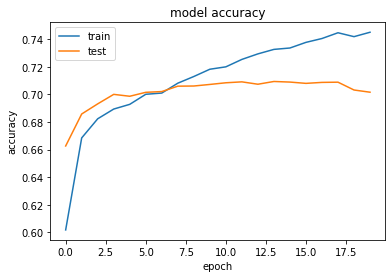

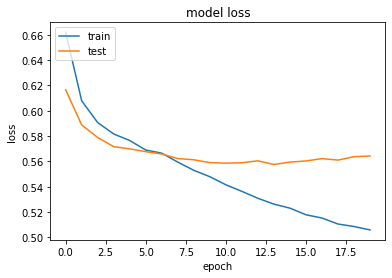

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## CNN

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(32, 5, activation='relu'))
model.add(Dropout(0.4))

model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6251900   
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            16032     
                                                                 
 dropout_2 (Dropout)         (None, 96, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            10304     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

In [ ]:
batch_size = 128
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

Epoch 1/10
800/800 [==============================] - 73s 91ms/step - loss: 0.5916 - accuracy: 0.6769 - val_loss: 0.5427 - val_accuracy: 0.7285
Epoch 2/10
800/800 [==============================] - 71s 89ms/step - loss: 0.5407 - accuracy: 0.7249 - val_loss: 0.5319 - val_accuracy: 0.7387
Epoch 3/10
800/800 [==============================] - 72s 90ms/step - loss: 0.5230 - accuracy: 0.7395 - val_loss: 0.5249 - val_accuracy: 0.7450
Epoch 4/10
800/800 [==============================] - 71s 88ms/step - loss: 0.5104 - accuracy: 0.7480 - val_loss: 0.5219 - val_accuracy: 0.7508
Epoch 5/10
800/800 [==============================] - 85s 107ms/step - loss: 0.5030 - accuracy: 0.7519 - val_loss: 0.5122 - val_accuracy: 0.7547
Epoch 6/10
800/800 [==============================] - 81s 101ms/step - loss: 0.4962 - accuracy: 0.7578 - val_loss: 0.5073 - val_accuracy: 0.7596
Epoch 7/10
800/800 [==============================] - 65s 81ms/step - loss: 0.4899 - accuracy: 0.7606 - val_loss: 0.5221 - val_accurac

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1000/1000 [==============================] - 12s 11ms/step - loss: 0.5076 - accuracy: 0.7504
Test Score: 0.5076179504394531
Test Accuracy: 0.7504374980926514


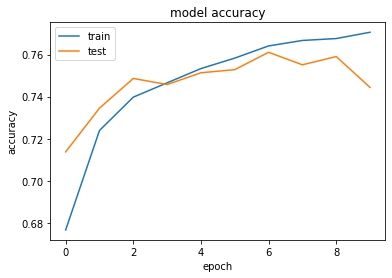

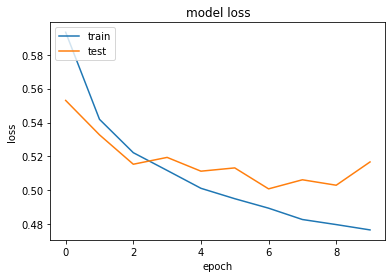

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## RNN

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          6251900   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,369,277
Trainable params: 117,377
Non-trainable params: 6,251,900
_________________________________________________________________
None


In [ ]:
batch_size = 256
epochs = 3

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
400/400 [==============================] - 285s 713ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4974
Epoch 2/3
400/400 [==============================] - 278s 696ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.4974
Epoch 3/3
344/400 [========================>.....] - ETA: 36s - loss: 0.6932 - accuracy: 0.4994

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3433817608118057
Test Accuracy: 0.8517


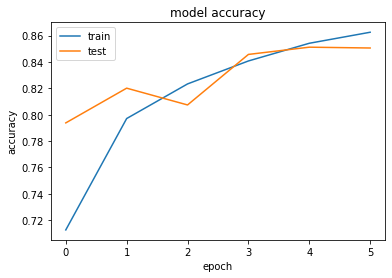

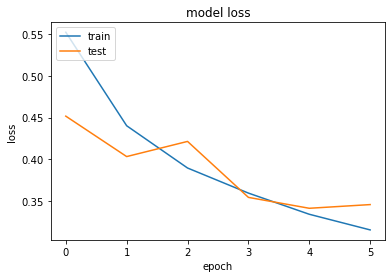

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.808128]], dtype=float32)